In [1]:
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from utils import get_data_matrix, train_model, validate_model, cross_val_model, plot_cross_val_metrics
from datasets import MEGDataset
from models import BaseMEGCNN, MultiViewCNN, BaseMEGEEGNet


In [2]:
with open("norm_dict.pkl", "rb") as f:
    norm_dict = pickle.load(f)

In [3]:
def add_noise(x: torch.Tensor, noise_level=0.01):
    noise = torch.randn_like(x) * noise_level
    return x + noise

## Intra

In [ ]:
def custom_loss(output, labels):
    loss_fn = nn.CrossEntropyLoss()

    y_logits, domain_logits = output
    class_labels, domain_labels = labels

    loss_cls = loss_fn(y_logits, class_labels)
    loss_domain = loss_fn(domain_logits, domain_labels)
    
    return loss_cls + 0.2 * loss_domain


In [ ]:
model_cls = MultiViewCNN
optim_cls = torch.optim.Adam
dataset_cls = MEGDataset

loss_fc = custom_loss
epochs = 1
data_path = '../data_2/Intra/train'

transforms = [
    lambda x: add_noise(x, noise_level=0.05)
]

optim_params = {
    'lr': 1e-3,
    'weight_decay': 1e-3,
}
model_params = {
    'base_cnn_cls': BaseMEGEEGNet,
    'hidden_size': 64,
    'dropout_prob': 0.5,
    'dropchannel_p': 0.5,
    'num_segments': 9,
}
data_params = {
    'downsampling_size': 100,
    'continous': True,
    'multiple': True,
    'num_segments': 13,
    'per_person_norm': norm_dict,
    'person_id': True
}

cv_metrics = cross_val_model(data_path, model_cls, optim_cls, dataset_cls, loss_fc, transforms=transforms,
    epochs=epochs, optim_params=optim_params, model_params=model_params, data_params=data_params)
plot_cross_val_metrics(cv_metrics)


100%|██████████| 1/1 [00:04<00:00,  4.16s/it]


Split: ('1', '2'), train_loss: 1.6863, val_loss: 1.6948, train_acc: 0.3750, val_acc: 0.2500


  0%|          | 0/1 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [7]:

train_dataset = MEGDataset('../data_2/Intra/train', transforms=transforms, **data_params)
train_dataloader = DataLoader(train_dataset, batch_size=32)

test_dataset = MEGDataset('../data_2/Intra/test', transforms=(), **data_params)
test_dataloader = DataLoader(test_dataset, batch_size=8)

model = model_cls(**model_params)
optim = optim_cls(model.parameters(), **optim_params)

scores = train_model(train_dataloader, test_dataloader, model, optim, loss_fc, epochs=20)
validate_model(test_dataloader, model, loss_fc)


100%|██████████| 20/20 [01:30<00:00,  4.53s/it]


(0.7530282735824585, 1.0)

## Cross

100%|██████████| 10/10 [01:41<00:00, 10.11s/it]


Split: ('1', '2'), train_loss: 1.6366, val_loss: 0.9023, train_acc: 0.6042, val_acc: 0.7500


100%|██████████| 10/10 [01:38<00:00,  9.81s/it]


Split: ('3', '4'), train_loss: 2.5872, val_loss: 2.3625, train_acc: 0.6250, val_acc: 0.6250


100%|██████████| 10/10 [01:42<00:00, 10.21s/it]


Split: ('5', '6'), train_loss: 1.4274, val_loss: 1.7879, train_acc: 0.7292, val_acc: 0.6875


100%|██████████| 10/10 [01:37<00:00,  9.73s/it]

Split: ('7', '8'), train_loss: 2.7015, val_loss: 4.8165, train_acc: 0.7083, val_acc: 0.5625


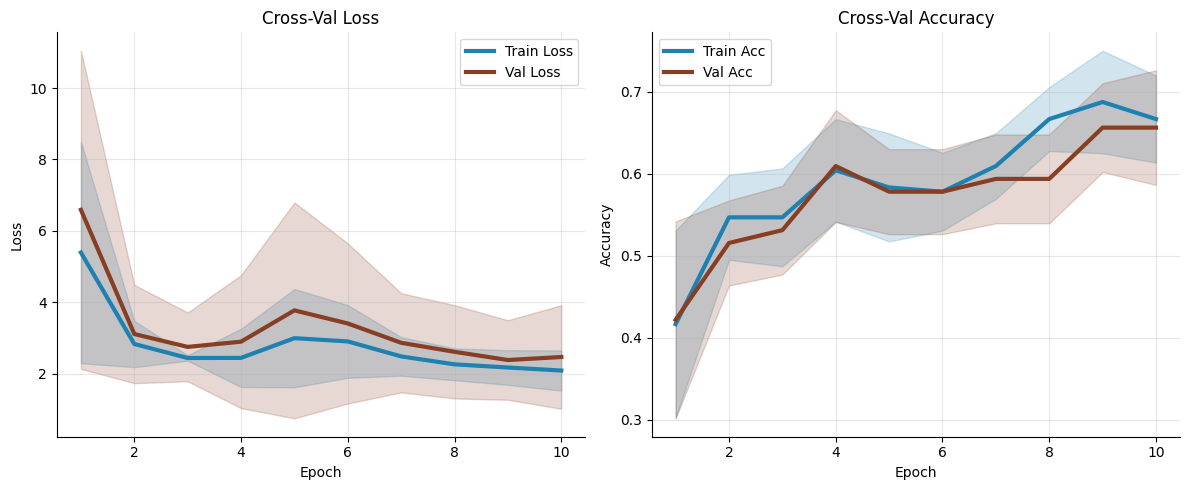

In [8]:
epochs = 10
data_path = '../data_2/Cross/train'

cv_metrics = cross_val_model(data_path, model_cls, optim_cls, dataset_cls, loss_fc, transforms=transforms,
    epochs=epochs, optim_params=optim_params, model_params=model_params, data_params=data_params)
plot_cross_val_metrics(cv_metrics)


In [34]:
test_dataset = MEGDataset('../data_2/Cross/test1', transforms=transforms, **data_params)
test_dataloader = DataLoader(test_dataset, batch_size=16)

train_dataset = MEGDataset('../data_2/Cross/train', transforms=(), **data_params)
train_dataloader = DataLoader(train_dataset, batch_size=64)

model = model_cls(**model_params)
optim = optim_cls(model.parameters(), **optim_params)

scores = train_model(train_dataloader, test_dataloader, model, optim, loss_fc, epochs=50)


100%|██████████| 50/50 [05:51<00:00,  7.03s/it]


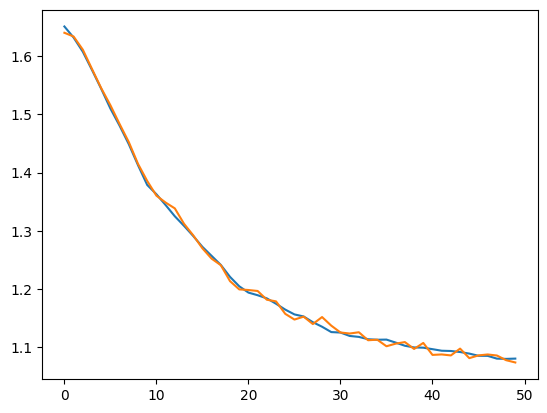

In [35]:
plt.plot(scores[0])
plt.plot(scores[2])

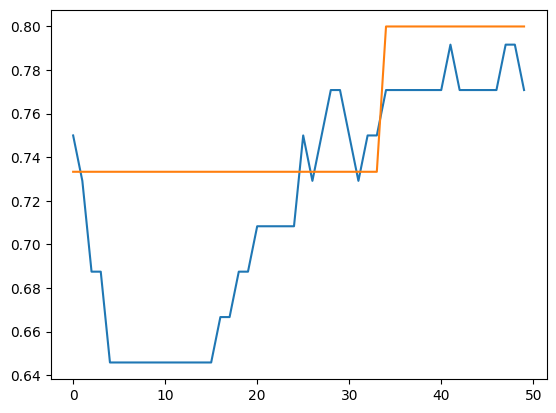

In [37]:
plt.plot(scores[1])
plt.plot(scores[3])

In [38]:
test_dataset = MEGDataset('../data_2/Cross/test1', mode='test', transforms=(), **data_params)
test_dataloader_1 = DataLoader(test_dataset, batch_size=16)
validate_model(test_dataloader_1, model, loss_fc)

(1.0589585304260254, 0.8125)

In [39]:
test_dataset = MEGDataset('../data_2/Cross/test2', mode='test', transforms=(), **data_params)
test_dataloader_2 = DataLoader(test_dataset, batch_size=16)
validate_model(test_dataloader_2, model, loss_fc)

(1.754050850868225, 0.4375)

In [40]:
test_dataset = MEGDataset('../data_2/Cross/test3', mode='test', transforms=(), **data_params)
test_dataloader_3 = DataLoader(test_dataset, batch_size=16)
validate_model(test_dataloader_3, model, loss_fc)

(1.6104068756103516, 0.6875)

In [46]:
accuracies = []

for i, dataloader in enumerate([test_dataloader_1, test_dataloader_2, test_dataloader_3], start=1):
    X, y = next(iter(dataloader))
    out = model(X)
    pred = out[0].argmax(dim=1)
    acc = (pred == y[0]).float().mean().item()
    accuracies.append(acc)
    print(f"test_dataloader_{i} - acc: {acc:.4f}")
    print(f"pred: {pred}, true: {y}")

avg_acc = sum(accuracies) / len(accuracies)
print(f"Mean acc: {avg_acc:.4f}")

test_dataloader_1 - acc: 0.8750
pred: tensor([0, 0, 0, 0, 1, 1, 1, 3, 2, 2, 2, 2, 1, 3, 3, 3]), true: [tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
test_dataloader_2 - acc: 0.4375
pred: tensor([0, 0, 0, 0, 3, 3, 1, 3, 3, 3, 3, 1, 3, 2, 3, 2]), true: [tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
test_dataloader_3 - acc: 0.5625
pred: tensor([0, 0, 0, 0, 2, 3, 2, 2, 2, 2, 3, 3, 3, 2, 3, 3]), true: [tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3]), tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]
Mean acc: 0.6250
